In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import preprocessing
import air_traff_utils as atu
import geopandas as gpd
import ipdb

In [2]:
atu.setup_seed(12)

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [4]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [5]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [6]:
data_X = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'INTPTLAT', 'INTPTLON', 'geometry', 'if_plot'], axis=1))
data_X.index = range(data_X.shape[0])

In [7]:
data_X['CSA_Code'] = ''
for i in data_X.index:
    CSA_Name = data_X.loc[i, 'CSA_Name']
    data_X.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

print(data_X.shape)
data_X.head(2)

(24, 20)


,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,CSA_Name,CSA_Code
0,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,5.484528,18.586822,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


In [8]:
data_X = data_X.drop(['AutoOwn1', 'AutoOwn2p', 'TotEmp', 'E_LowWageW', 'E_MedWageW', 'E_HiWageWk', 'D4D', 'D5AE', 'D5AR'], axis=1)
print(data_X.shape)
data_X.head(2)
att_lst = data_X.iloc[:, :data_X.shape[0]-2].columns
print(att_lst)

(24, 11)
Index(['TotPop', 'AutoOwn0', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C',
       'NatWalkInd', 'CSA_Name', 'CSA_Code'],
      dtype='object')


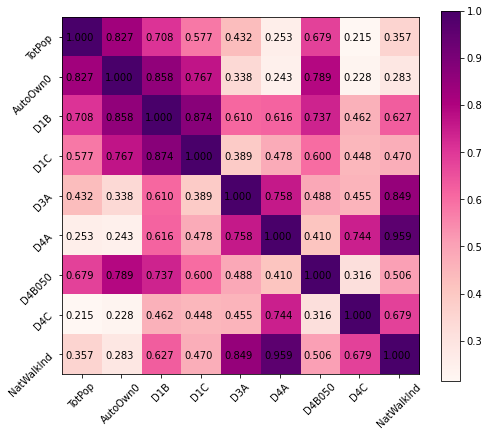

In [9]:
plt.figure(figsize=[8, 8])
heat_plot_data_X = data_X.iloc[:, :9]
plt.imshow(heat_plot_data_X.corr(), cmap='RdPu')
for i in range(9):  # 9 features, number may subject to change
    for j in range(9):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X.corr().iloc[i, j]))
plt.xticks(range(9), list(heat_plot_data_X.columns), rotation = 45)
plt.yticks(range(9), list(heat_plot_data_X.columns), rotation = 45)
plt.colorbar(shrink=0.85)

(24, 24)


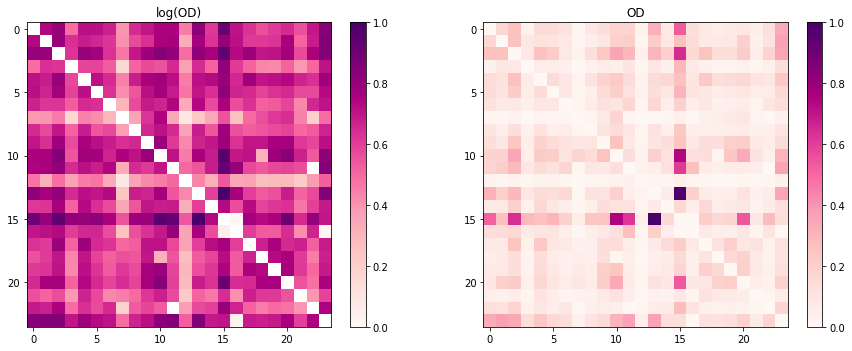

In [10]:
print(OD_df.shape)
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(121)
ax1.imshow(np.log(OD_df), cmap='RdPu')
ax1.set_title('log(OD)')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(122)
ax2.imshow(OD_df, cmap='RdPu')
ax2.set_title('OD')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax2, shrink=0.8)

# Prepare Feature Pairs (X)

In [11]:
def get_logOD(OD):
    # OD is originally DataFrame
    OD = np.array(OD)
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            if OD[i, j]!=0:
                OD[i, j] = np.log(OD[i, j])
    return OD

In [12]:
data_X = np.array(data_X.iloc[:, :9])
# scalar_data_X = preprocessing.StandardScaler().fit(data_X)
# data_X = scalar_data_X.transform(data_X)  # shape: [num_cities * num_features*2+1, 1]
print('data_X | Shape:', data_X.shape, ', type: %s'%type(data_X))

# ################# NOTE ####################
# this OD is logged                         #
# OD = get_logOD(OD_df)                     #
# ###########################################
OD = np.array(OD_df)  # shape: [num_cities, num_cities]
# preprocessing.StandardScaler(), see:
# https://scikit-learn.org/stable/modules/preprocessing.html
scalar_OD = preprocessing.MinMaxScaler().fit(OD)
OD = scalar_OD.transform(OD)
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

data_X | Shape: (24, 9) , type: <class 'numpy.ndarray'>
OD | Shape: (24, 24) , type: <class 'numpy.ndarray'>


In [13]:
print(us_CSA_use.shape)
us_CSA_use.head(2)


(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [14]:
att_lst

Index(['TotPop', 'AutoOwn0', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C',
       'NatWalkInd', 'CSA_Name', 'CSA_Code'],
      dtype='object')

In [15]:
# 24代表了24个机场，9代表了9个特征，
# OD是要预测的对象（y）
# 现在要把变成 X【576,19】，where 576=24*24,19=2*9+1
# 2*9代表出发地和目的地各有9个特征，1代表两地之间的特征
# 因为目的是要训练一个函数 f：X->y
# 也就是说输入【576,19】，输出【576,1】
# Write your code here...

In [16]:
data_X_distance = pd.DataFrame(us_CSA_use.copy()[['INTPTLAT','INTPTLON']])
data_X_distance = data_X_distance.reset_index().drop(['index'],axis = 1)
data_X_distance

,INTPTLAT,INTPTLON
0,33.834001,-84.305803
1,42.293282,-71.237945
2,35.253135,-80.858513
3,41.843309,-87.838419
4,32.866550,-96.929076
5,39.794497,-104.971125
6,42.495622,-83.284399
7,29.756075,-95.413286
8,36.157189,-115.165292
9,34.005801,-117.999677


In [17]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [18]:
a = pd.DataFrame(data_X)
a.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,6.584708e+06,8.200935e+06,2.656704e+06,9.907569e+06,7.651710e+06,3.466374e+06,5.340674e+06,6.963733e+06,2.185279e+06,1.862904e+07,...,3.901932e+06,7.176556e+06,4.727034e+06,2.511156e+06,3.302833e+06,9.549567e+06,4.691993e+06,3.030047e+06,987638.000000,9.664499e+06
1,1.422570e+05,3.497740e+05,5.121900e+04,4.307050e+05,1.281830e+05,7.227800e+04,1.823470e+05,1.237220e+05,6.508200e+04,4.180370e+05,...,7.537400e+04,3.324890e+05,1.007990e+05,3.317900e+04,6.148600e+04,2.942620e+05,1.353910e+05,8.211000e+04,30359.000000,3.419670e+05
2,4.184264e+00,1.335781e+01,3.010412e+00,1.656674e+01,8.184023e+00,9.660243e+00,6.713886e+00,8.552114e+00,1.234017e+01,1.784333e+01,...,4.375730e+00,1.545272e+01,8.589013e+00,7.805913e+00,1.469946e+01,1.690752e+01,8.819025e+00,8.843087e+00,23.310723,1.309011e+01
3,2.193174e+00,5.484528e+00,2.051535e+00,5.157357e+00,2.687314e+00,3.828745e+00,1.961696e+00,3.281493e+00,3.387243e+00,4.906058e+00,...,2.144312e+00,4.446900e+00,2.727567e+00,2.792948e+00,3.850653e+00,6.169114e+00,4.586079e+00,3.173562e+00,9.425124,6.486531e+00
4,1.180804e+01,1.858682e+01,1.095275e+01,2.239762e+01,1.910626e+01,2.108491e+01,1.759925e+01,1.924460e+01,2.373095e+01,2.294709e+01,...,1.482396e+01,2.084885e+01,2.026259e+01,1.697577e+01,2.166007e+01,2.239628e+01,1.728490e+01,1.920170e+01,18.872524,1.802254e+01
5,-6.795551e+04,-3.925581e+04,-7.333311e+04,-3.563353e+04,-5.426183e+04,-3.464713e+04,-6.865874e+04,-5.775521e+04,-2.425092e+04,-1.844997e+04,...,-5.782400e+04,-3.043670e+04,-3.956295e+04,-3.075655e+04,-2.474076e+04,-2.477775e+04,-3.162705e+04,-3.782535e+04,-17160.536058,-3.762969e+04
6,2.677805e-02,1.504675e-01,3.122448e-02,2.230239e-01,4.072474e-02,6.263469e-02,4.959738e-03,2.276828e-02,7.820470e-02,7.462293e-02,...,1.465031e-02,2.363747e-01,3.379665e-02,9.441790e-02,1.011176e-01,1.577067e-01,4.220484e-02,1.122545e-02,0.000000,1.062998e-01
7,-6.027686e+04,-2.879966e+04,-6.255107e+04,-3.127025e+04,-5.156806e+04,-2.780336e+04,-6.756923e+04,-5.449715e+04,-1.980853e+04,-1.635408e+04,...,-5.660205e+04,-2.003494e+04,-3.364386e+04,-2.284972e+04,-7.570705e+04,-2.634849e+04,-2.025293e+04,-2.622330e+04,-3711.848477,-3.059673e+04
8,8.498581e+00,1.134276e+01,8.136293e+00,1.170701e+01,9.901212e+00,1.168316e+01,8.900744e+00,9.985997e+00,1.183827e+01,1.289065e+01,...,9.564029e+00,1.198180e+01,1.083855e+01,1.183574e+01,1.218663e+01,1.261734e+01,1.118569e+01,1.101744e+01,11.998872,1.084463e+01


In [19]:
X = pd.DataFrame()
X[0] = a.T[0].append(a.T[1])
X

,0
0,6.584708e+06
1,1.422570e+05
2,4.184264e+00
3,2.193174e+00
4,1.180804e+01
5,-6.795551e+04
6,2.677805e-02
7,-6.027686e+04
8,8.498581e+00
0,8.200935e+06


In [20]:
X = pd.DataFrame()
for i in range(24):
    for j in range(24):
        X[i*24+j] = a.T[i].append(a.T[j])

C:\Users\10169\AppData\Local\Temp/ipykernel_2384/3694206904.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[i*24+j] = a.T[i].append(a.T[j])


In [21]:
X = X.reset_index().drop(['index'],axis = 1).T
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581
1,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,8200935.0,349774.0,13.357811,5.484528,18.586822,-39255.813819,0.150468,-28799.664050,11.342761
2,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,2656704.0,51219.0,3.010412,2.051535,10.952750,-73333.114672,0.031224,-62551.073532,8.136293
3,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,9907569.0,430705.0,16.566744,5.157357,22.397624,-35633.525790,0.223024,-31270.250343,11.707006
4,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,7651710.0,128183.0,8.184023,2.687314,19.106257,-54261.834537,0.040725,-51568.055467,9.901212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,9549567.0,294262.0,16.907516,6.169114,22.396279,-24777.752218,0.157707,-26348.489942,12.617343
572,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,4691993.0,135391.0,8.819025,4.586079,17.284904,-31627.048329,0.042205,-20252.932636,11.185688
573,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,3030047.0,82110.0,8.843087,3.173562,19.201696,-37825.352038,0.011225,-26223.297561,11.017435
574,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,987638.0,30359.0,23.310723,9.425124,18.872524,-17160.536058,0.000000,-3711.848477,11.998872


In [22]:
col_19 = []
for i in range(24):
    for j in range(24):
        lat1 = data_X_distance.iloc[i,0]
        lon1 = data_X_distance.iloc[i,1]
        lat2 = data_X_distance.iloc[j,0]
        lon2 = data_X_distance.iloc[j,1]
        col_19.append(distance(lat1, lat2, lon1, lon2))
X['18'] = col_19
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,0.000000
1,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,8200935.0,349774.0,13.357811,5.484528,18.586822,-39255.813819,0.150468,-28799.664050,11.342761,1478.074584
2,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,2656704.0,51219.0,3.010412,2.051535,10.952750,-73333.114672,0.031224,-62551.073532,8.136293,352.945623
3,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,9907569.0,430705.0,16.566744,5.157357,22.397624,-35633.525790,0.223024,-31270.250343,11.707006,942.836703
4,6584708.0,142257.0,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,8.498581,7651710.0,128183.0,8.184023,2.687314,19.106257,-54261.834537,0.040725,-51568.055467,9.901212,1176.675968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,9549567.0,294262.0,16.907516,6.169114,22.396279,-24777.752218,0.157707,-26348.489942,12.617343,3882.824622
572,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,4691993.0,135391.0,8.819025,4.586079,17.284904,-31627.048329,0.042205,-20252.932636,11.185688,3730.892530
573,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,3030047.0,82110.0,8.843087,3.173562,19.201696,-37825.352038,0.011225,-26223.297561,11.017435,1326.833471
574,9664499.0,341967.0,13.090115,6.486531,18.022541,-37629.689614,0.106300,-30596.733734,10.844635,987638.0,30359.0,23.310723,9.425124,18.872524,-17160.536058,0.000000,-3711.848477,11.998872,7773.011209


In [23]:
X = np.array(X)
scalar_X = preprocessing.StandardScaler().fit(X)
X = scalar_X.transform(X)  # shape: [num_cities^2, 19]
print('X | Shape:', X.shape, ', type: %s'%type(X))

OD = OD.reshape(-1, 1)
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

X | Shape: (576, 19) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


# Define Gravity Model

In [24]:
# Model specification
class DeepGravityNet(nn.Module):
    def __init__(self, inp_dim, hid_dim=256, out_dim=1, dropout_p=0.35):
        super(DeepGravityNet, self).__init__()
        
        self.deep_graivty_fc1 = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.deep_graivty_fc2 = nn.Sequential(
            
            nn.Linear(hid_dim, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, hid_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hid_dim // 2, inp_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        self.out_fc = nn.Sequential(
            nn.Linear(inp_dim, 1),
            nn.ReLU()
        )
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        y = self.deep_graivty_fc1(x)
        y = nn.BatchNorm1d(y.shape[1], device=device)(y)
        # shape of "x" here = [batchsize, sequence_len, 256]
        y = self.deep_graivty_fc2(y)
        y += x
        y = self.out_fc(y)
        return y
    

# Preparing Data for Pytorch

In [25]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop = 0.7
l = int(X.shape[0]*prop)

X_train = torch.tensor(X[:l, :], dtype=torch.float32).to(device)
y_train = torch.tensor(OD[:l, :], dtype=torch.float32).to(device)
X_val = torch.tensor(X[l:, :], dtype=torch.float32).to(device)
y_val = torch.tensor(OD[l:, :], dtype=torch.float32).to(device)

batch_size = 2500
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)


# Initialize the Model

In [26]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
inp_dim = X.shape[-1]
model = DeepGravityNet(inp_dim).to(device)
loss_func = nn.MSELoss()  # reconstruction loss function

loss_set_train = []
loss_set_val = []

print('There are %i OD pairs'%OD.shape[0])


There are 576 OD pairs


# Train the Model

In [27]:
optimizer = optim.Adam(model.parameters())

In [28]:
out = model(X_train)

In [29]:
model.train()

epochs = 1000

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        out_val = model(X_val)
#         ipdb.set_trace()
        loss_val = loss_func(out_val, y_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:0.139804, train loss:0.191168
Epoch 50   success, val loss:0.099335, train loss:0.152753
Epoch 100   success, val loss:0.104504, train loss:0.079317
Epoch 150   success, val loss:0.110354, train loss:0.055029
Epoch 200   success, val loss:0.116430, train loss:0.047096
Epoch 250   success, val loss:0.124493, train loss:0.035612
Epoch 300   success, val loss:0.128717, train loss:0.027865
Epoch 350   success, val loss:0.135580, train loss:0.025495
Epoch 400   success, val loss:0.134331, train loss:0.024364
Epoch 450   success, val loss:0.135214, train loss:0.019203
Epoch 500   success, val loss:0.141194, train loss:0.020491
Epoch 550   success, val loss:0.137938, train loss:0.017108
Epoch 600   success, val loss:0.144709, train loss:0.015493
Epoch 650   success, val loss:0.144111, train loss:0.014234
Epoch 700   success, val loss:0.141961, train loss:0.013903
Epoch 750   success, val loss:0.140640, train loss:0.013563
Epoch 800   success, val loss:0.150785, tra

In [30]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

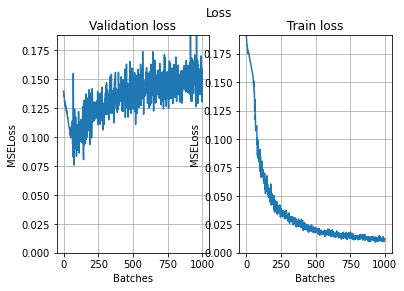

In [31]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

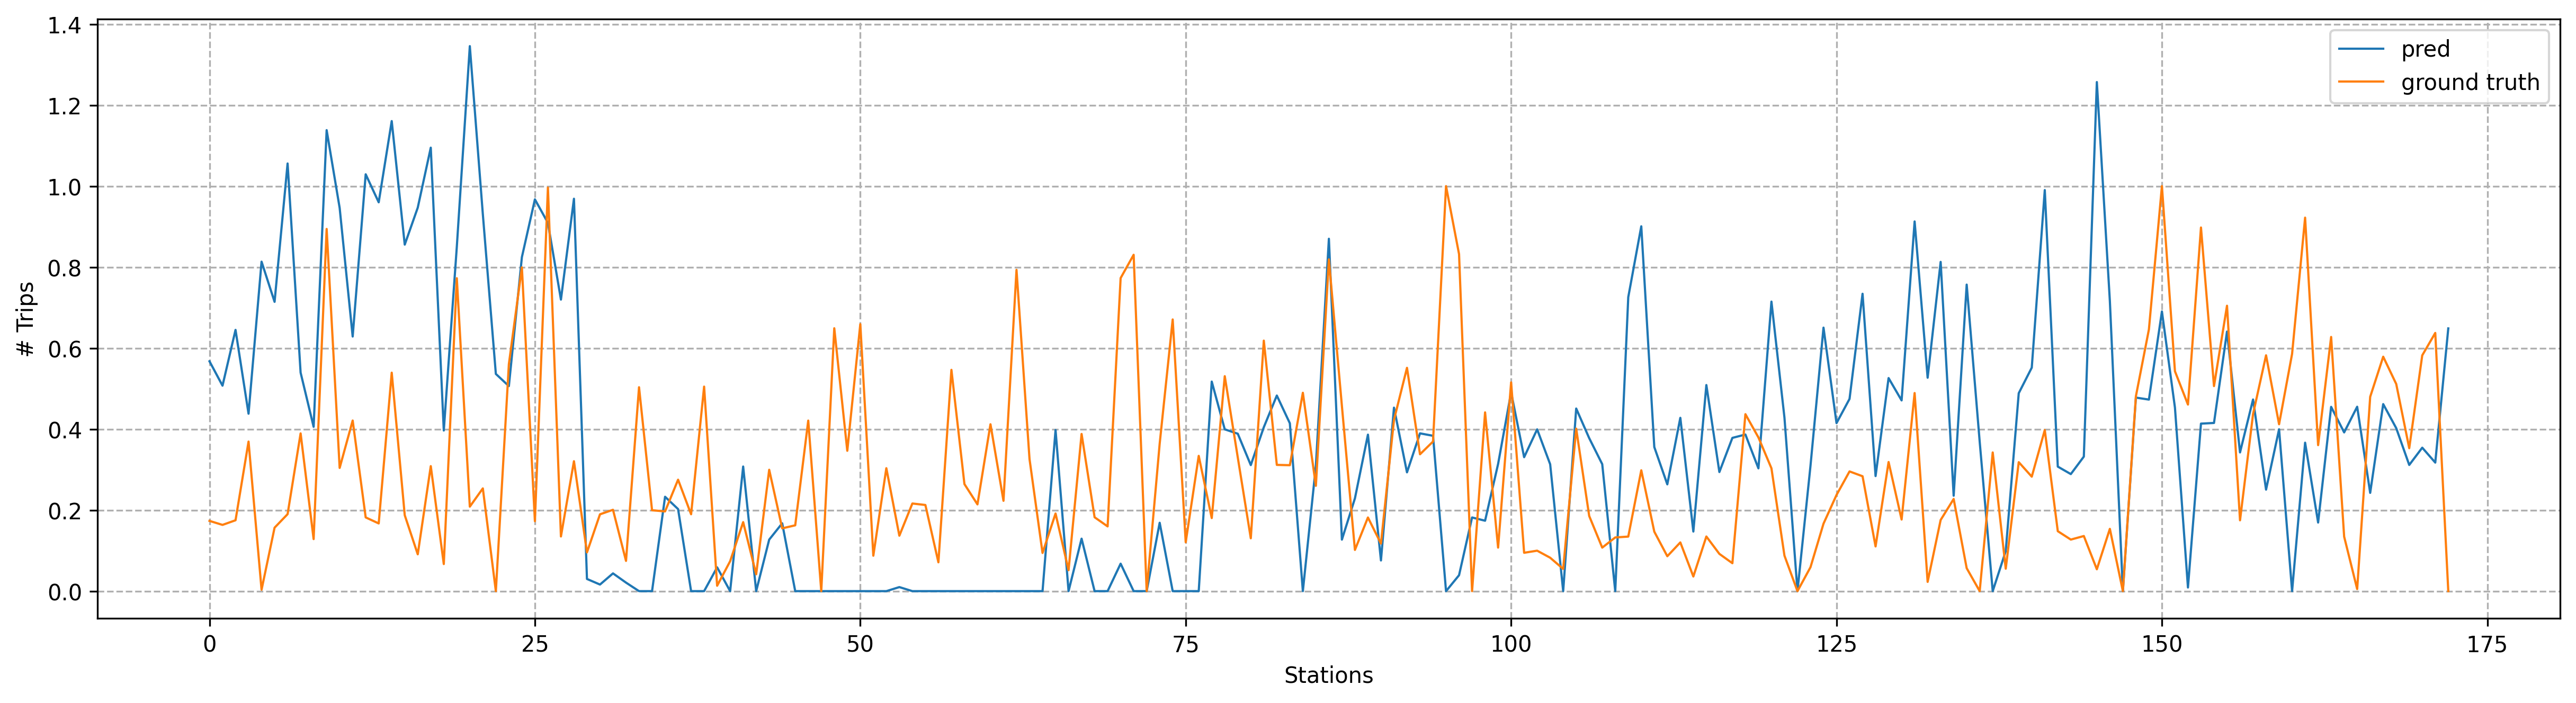

In [32]:
plt.figure(figsize=[20,5], dpi=300)
plt.plot(out_val.cpu().detach().numpy()[:650, 0], label='pred', lw=1)
plt.plot(y_val.cpu().detach().numpy()[:650, 0], label='ground truth', lw=1)
plt.xlabel('Stations')
plt.ylabel('# Trips')
plt.legend()
plt.grid(ls='--')

In [33]:
pred = out_val.cpu().detach().numpy()[:650, :]

labels = y_val.cpu().detach().numpy()[:650, :]

m = 0.1

print('The mae loss is %.4f'%atu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%atu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%atu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%atu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%atu.nmae_loss_func(pred, labels, m))



The mae loss is 0.3048
The mape loss is 4.6354
The smape loss is 0.7954
The nrmse loss is 0.3944
The nmae loss is 0.3048


C:\Users\10169\Documents\Github\Air_Traffic\air_traff_utils.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))


In [34]:
def get_CPC(pred, labels):
    res_min = np.concatenate([pred, labels], axis=1).min(axis=1).flatten()
    CPC = np.sum(res_min)*2 / (np.sum(pred) + np.sum(labels))
    return CPC

In [35]:
print('CPC is %.5f'%get_CPC(pred, labels))

CPC is 0.55109


In [54]:
np.save('./res/deep_grav_labels.npy', y_val.cpu().detach().numpy())
np.save('./res/deep_grav_pred.npy', out_val.cpu().detach().numpy())

In [53]:
np.save('./res/deep_grav_input.npy', np.array(X_val.cpu().detach().numpy()))